# Chapter 6 - Evolutionary Algorithms
### Deep Reinforcement Learning *in Action*

##### Listing 6.1

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt

alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.! " #A
target = "Hello World!" #B

class Individual: #C
    def __init__(self, string, fitness=0):
        self.string = string
        self.fitness = fitness

from difflib import SequenceMatcher

def similar(a, b): #D
    return SequenceMatcher(None, a, b).ratio()

def spawn_population(length=26,size=100): #E
    pop = []
    for i in range(size):
        string = ''.join(random.choices(alphabet,k=length))
        individual = Individual(string)
        pop.append(individual)
    return pop

#A This is the list of characters we sample from to produce random strings
#B This is the string we’re trying to evolve from a random population
#C We set up a simple class to store information about each member of the population
#D This method will compute a similarity metric between two strings, giving us a fitness score
#E This method will produce an initial random population of strings

##### Listing 6.2

In [2]:
def recombine(p1_, p2_): #A
    p1 = p1_.string
    p2 = p2_.string
    child1 = []
    child2 = []
    cross_pt = random.randint(0,len(p1))
    child1.extend(p1[0:cross_pt])
    child1.extend(p2[cross_pt:])
    child2.extend(p2[0:cross_pt])
    child2.extend(p1[cross_pt:])
    c1 = Individual(''.join(child1))
    c2 = Individual(''.join(child2))
    return c1, c2

def mutate(x, mut_rate=0.01): #B
    new_x_ = []
    for char in x.string:
        if random.random() < mut_rate:
            new_x_.extend(random.choices(alphabet,k=1))
        else:
            new_x_.append(char)
    new_x = Individual(''.join(new_x_))
    return new_x

#A This function recombines two parent strings into two new offspring
#B This function will mutate a string by randomly flipping characters

##### Listing 6.3

In [3]:
def evaluate_population(pop, target): #A
    avg_fit = 0
    for i in range(len(pop)):
        fit = similar(pop[i].string, target)
        pop[i].fitness = fit
        avg_fit += fit
    avg_fit /= len(pop)
    return pop, avg_fit

def next_generation(pop, size=100, length=26, mut_rate=0.01): #B
    new_pop = []
    while len(new_pop) < size:
        parents = random.choices(pop,k=2, weights=[x.fitness for x in pop])
        offspring_ = recombine(parents[0],parents[1])
        child1 = mutate(offspring_[0], mut_rate=mut_rate)
        child2 = mutate(offspring_[1], mut_rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

#A This function assigns a fitness score to each individual in the population
#B This function generates a new generation by recombination and mutation

##### Listing 6.4

In [4]:
num_generations = 150
population_size = 900
str_len = len(target)
mutation_rate = 0.00001 #A

pop_fit = []
pop = spawn_population(size=population_size, length=str_len) #B
done = False
for gen in range(num_generations):
    pop, avg_fit = evaluate_population(pop, target)
    pop_fit.append(avg_fit) #C
    new_pop = next_generation(pop, \
        size=population_size, length=str_len, mut_rate=mutation_rate)
    pop = new_pop
    for x in pop: 
        if x.string == target: 
            print("Target Found!")
            done = True
    if done:
        break
#A Set the mutation rate to 0.1%
#B Create the initial random population
#C Record population average fitness over training time

Target Found!


In [5]:
pop.sort(key=lambda x: x.fitness, reverse=True) #sort in place, highest fitness first
pop[0].string

'HllHoWr.rod!'

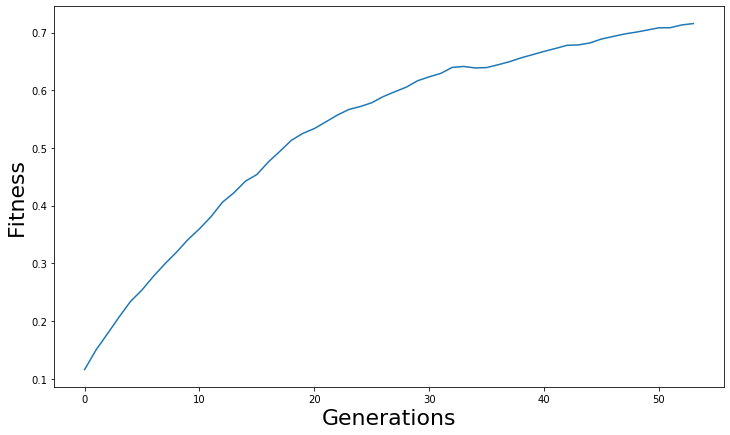

In [6]:
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Fitness",fontsize=22)
plt.plot(pop_fit)

##### Listing 6.5
CartPole Example

In [7]:
import torch

Total number of parameters: $4*25 + 25 + 10*25 + 10 + 2*10 + 2 = 407$

In [8]:
def model(x,unpacked_params):
    l1,b1,l2,b2,l3,b3 = unpacked_params #A
    y = torch.nn.functional.linear(x,l1,b1) #B
    y = torch.relu(y) #C
    y = torch.nn.functional.linear(y,l2,b2)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y,l3,b3)
    y = torch.log_softmax(y,dim=0) #D
    return y

#A Unpack the parameter vector into individual layer matrices
#B Simple linear layer with bias
#C Rectified linear unit activation function
#D The last layer will output log-probabilities over actions

##### Listing 6.6

In [9]:
def unpack_params(params, layers=[(25,4),(10,25),(2,10)]): #A
    unpacked_params = [] #B
    e = 0
    for i,l in enumerate(layers): #C
        s,e = e,e+np.prod(l)
        weights = params[s:e].view(l) #D
        s,e = e,e+l[0]
        bias = params[s:e]
        unpacked_params.extend([weights,bias]) #E
    return unpacked_params

#A The `layers` parameter specifies the shape of each layer matrix
#B Store each individual layer tensor
#C Iterate through each layer
#D Unpack the indivudal layer into matrix form
#E Add the unpacked tensor to the list

##### Listing 6.7

In [10]:
def spawn_population(N=50,size=407): #A
    pop = []
    for i in range(N):
        vec = torch.randn(size) / 2.0 #B
        fit = 0
        p = {'params':vec, 'fitness':fit} #C
        pop.append(p)
    return pop

#A `N` is the number of individuals in the population, `size` is the length of the parameter vectors
#B Create a randomly initialized parameter vector
#C Create a dictionary to store the parameter vector and its associated fitness score

##### Listing 6.8

In [11]:
def recombine(x1,x2): #A
    x1 = x1['params'] #B
    x2 = x2['params']
    l = x1.shape[0]
    split_pt = np.random.randint(l) #C
    child1 = torch.zeros(l)
    child2 = torch.zeros(l)
    child1[0:split_pt] = x1[0:split_pt] #D
    child1[split_pt:] = x2[split_pt:]
    child2[0:split_pt] = x2[0:split_pt]
    child2[split_pt:] = x1[split_pt:]
    c1 = {'params':child1, 'fitness': 0.0} #E
    c2 = {'params':child2, 'fitness': 0.0}
    return c1, c2

#A x1 and x2 are agents which are dictionaries
#B Extract just the parameter vector
#C Randomly produce a split or crossover point
#D The first child is produced by taking the first segment of parent 1 and the second segment of parent 2
#E Create new children agents by packaging the new parameter vectors into dictionaries

##### Listing 6.9

In [12]:
def mutate(x, rate=0.01): #A
    x_ = x['params']
    num_to_change = int(rate * x_.shape[0]) #B
    idx = np.random.randint(low=0,high=x_.shape[0],size=(num_to_change,))
    x_[idx] = torch.randn(num_to_change) / 10.0 #C
    x['params'] = x_
    return x

#A `rate` is the mutation rate where 0.01 is a 1% mutation rate
#B Use the mutation rate to decide how many elements in the parameter vector to mutate
#C Randomly reset the selected elements in the parameter vector

##### Listing 6.10

In [13]:
import gym
env = gym.make("CartPole-v0")

In [14]:
def test_model(agent):
    done = False
    state = torch.from_numpy(env.reset()).float()
    score = 0
    while not done: #A
        params = unpack_params(agent['params'])
        probs = model(state,params) #B
        action = torch.distributions.Categorical(probs=probs).sample() #C
        state_, reward, done, info = env.step(action.item())
        state = torch.from_numpy(state_).float()
        score += 1 #D
    return score

#A While game is not lost
#B Get the action probabilities from the model using the agent's parameter vector
#C Probabilistically select an action by sampling from a categorical distribution
#D Keep track of the number of time steps the game is not lost as the score

##### Listing 6.11

In [15]:
def evaluate_population(pop):
    tot_fit = 0 #A
    lp = len(pop)
    for agent in pop: #B
        score = test_model(agent) #C
        agent['fitness'] = score #D
        tot_fit += score
    avg_fit = tot_fit / lp
    return pop, avg_fit

#A Total fitness for this population; used to later calculate the average fitness of the population
#B Iterate through each agent in the population
#C Run the agent in the environment to assess its fitness
#D Store the fitness value

##### Listing 6.12

In [16]:
def next_generation(pop,mut_rate=0.001,tournament_size=0.2):
    new_pop = []
    lp = len(pop)
    while len(new_pop) < len(pop): #A
        rids = np.random.randint(low=0,high=lp,size=(int(tournament_size*lp))) #B
        batch = np.array([[i,x['fitness']] for (i,x) in enumerate(pop) if i in rids]) #C
        scores = batch[batch[:, 1].argsort()] #D
        i0, i1 = int(scores[-1][0]),int(scores[-2][0]) #E
        parent0,parent1 = pop[i0],pop[i1]
        offspring_ = recombine(parent0,parent1) #F
        child1 = mutate(offspring_[0], rate=mut_rate) #G
        child2 = mutate(offspring_[1], rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

#A While the new population is not full
#B Select a percentage of the full population as a subset
#C Subset the population to get a batch of agents and match each one with their index value in the original population
#D Sort this batch in increasing order of score
#E The last agents in the sorted batch are the agents with the highest scores; select the top 2 as parents
#F Recombine the parents to get offspring
#G Mutate the children before putting them into the next generation

##### Listing 6.13

In [17]:
num_generations = 20 #A
population_size = 500 #B
mutation_rate = 0.01
pop_fit = []
pop = spawn_population(N=population_size,size=407) #C
for i in range(num_generations):
    pop, avg_fit = evaluate_population(pop) #D
    pop_fit.append(avg_fit)
    pop = next_generation(pop, mut_rate=mutation_rate,tournament_size=0.2) #E
    
#A The number of generations to evolve
#B The number of individuals in each generation
#C Initialize a population
#D Evaluate the fitness of each agent in the population
#E Populate the next generation

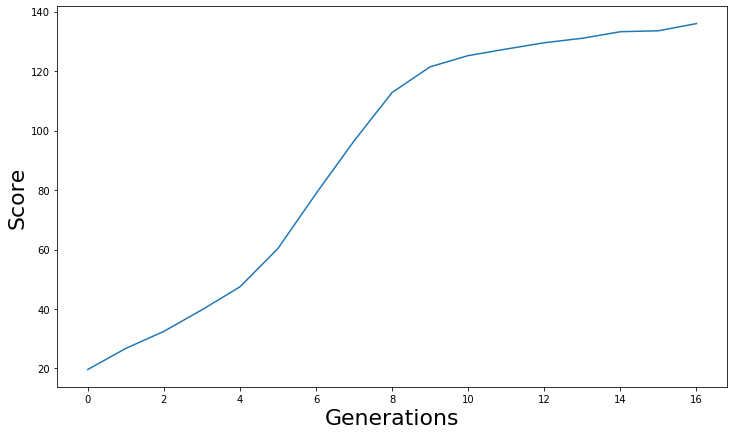

In [20]:
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Score",fontsize=22)
plt.plot(running_mean(np.array(pop_fit),3))

In [21]:
test_model(pop[0])

121

C:\Users\webse\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log


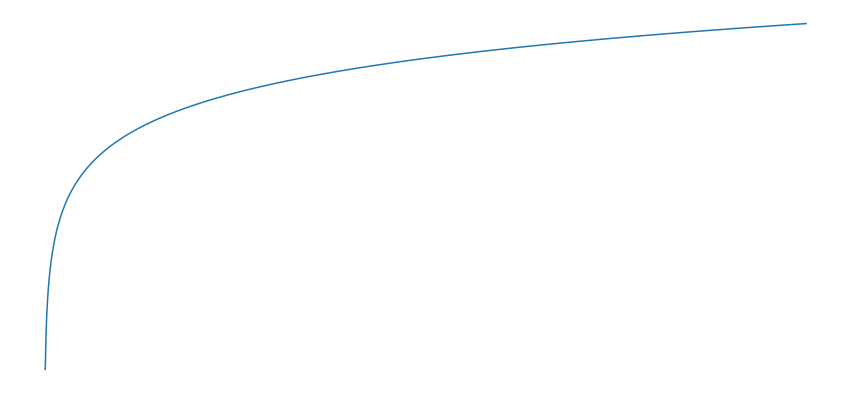

In [22]:
plt.figure(figsize=(15,7))
plt.axis('off')
plt.xlabel("Compute resources",fontsize=22)
plt.ylabel("Performance",fontsize=22)
x = np.linspace(0,100,1000)
y = np.log(x)
plt.plot(x,y)

In [19]:
def running_mean(x,n=5):
    conv = np.ones(n)
    y = np.zeros(x.shape[0]-n)
    for i in range(x.shape[0]-n):
        y[i] = (conv @ x[i:i+n]) / n
    return y